In [111]:
# For Data Manipulation
import pandas as pd
import numpy as np

# For Data Visualisation
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

# Stats packages
import statsmodels.api as sm

# For Machine Learning
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.base import clone
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import TweedieRegressor
from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.metrics import make_scorer, mean_tweedie_deviance
from sklearn.model_selection import(
    KFold,
    cross_validate,
    cross_val_predict,
    GridSearchCV,
    train_test_split
)

Profit is only realised for sold polciies so when modelling profit we need to focus on only the policies which sold

In [112]:
# Loading in the data and focusing on sold policies
df = pd.read_csv("Data\MockDataSet1_Cleaned.csv")
df_sold = df[df['Sold'] == 1]
df_sold

,QuoteRef,Channel,Product,Smoker,Joint?,Person1 Age,Term,TotalPremium,NBC,Sold,JF (Score),WGB (No. of other addresses held),X (Months same person on ER at current address),EF (No. of people not same surname at current address),NOB (Property group),URB (Income group),LSB (Regional banded house price band),BB (Number of CCJs),ND (Months since last CCJ)
11,FWPX-43,MSM,Decreasing with CI,1.0,1,42.0,20,11.05,228.57,1,558.0,2.0,NaN,6.0,14.0,4.0,2.0,0.0,NaN
12,OKEN-22,CTM,Level with CI,1.0,1,44.0,30,8.22,160.45,1,558.0,2.0,NaN,6.0,14.0,4.0,2.0,0.0,NaN
13,UCDW-29,Direct,Decreasing,0.0,0,45.0,30,8.22,160.45,1,558.0,2.0,NaN,6.0,14.0,4.0,2.0,0.0,NaN
14,AUQG-85,CTM,Level with CI,1.0,1,45.0,5,8.00,156.23,1,558.0,2.0,NaN,6.0,14.0,4.0,2.0,0.0,NaN
15,EXOK-80,CTM,Level with CI,1.0,0,36.0,20,8.22,160.45,1,558.0,2.0,NaN,6.0,14.0,4.0,2.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,ZYOC-42,CTM,Level,1.0,1,43.0,30,47.62,1030.00,1,556.0,4.0,NaN,3.0,17.0,3.0,1.0,0.0,NaN
2714,JNGP-14,CTM,Decreasing with CI,1.0,1,44.0,20,24.10,502.64,1,581.0,4.0,48.0,6.0,13.0,4.0,2.0,0.0,NaN
2715,OZDB-62,CTM,Decreasing,0.0,0,40.0,30,24.10,502.64,1,581.0,4.0,48.0,6.0,13.0,4.0,2.0,0.0,NaN
2719,QDGW-65,CTM,Decreasing with CI,0.0,1,50.0,30,24.10,502.64,1,581.0,4.0,48.0,6.0,13.0,4.0,2.0,0.0,NaN


In [113]:
# Making the train test split
df_train, df_test = train_test_split(df_sold, test_size=0.2, random_state=0)

# Saving the dataframes for future use
df_train.to_csv("Data\df_sold_train.csv", index=False)
df_test.to_csv("Data\df_sold_test.csv", index=False)

# Running the train test comparison report
# This ensures that the train and test sets are similar in terms of feature distribution
tt_report = sv.compare([df_train, "Training Data"], [df_test, "Test Data"])
tt_report.show_html('Sweetviz Reports\Train_Test_Comparison.html')

                                             |          | [  0%]   00:00 -> (? left)

Report Sweetviz Reports\Train_Test_Comparison.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [114]:
# Looking at a targetted report to build the pipeline
profit_report = sv.analyze(df_train, target_feat="NBC")
profit_report.show_html("Sweetviz Reports\profit_report.html")

                                             |          | [  0%]   00:00 -> (? left)

Report Sweetviz Reports\profit_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


### Including Premium

Including premium in a model for profit is an interesting topic because it can significantly impact the predictive power and interpretability of the model. The main issue is if including premium is a source of data leakeage for the model. It can be broken down into two scenarios:

- If NBC is derived from Total Premium (e.g., NBC = Total Premium - Costs), then Total Premium should NOT be included in the model because it already contains most of the information needed to predict NBC.
- If Total Premium is an independent input feature that does not directly determine NBC, then it can be included in the model.

I think scenario one is far more likely (also correlation was 0.97 in EDA) so I will be assuming it will introduce data leakeage and not include it in the modelling.

In [115]:
numeric_feats = [
    "Person1 Age",
    "Term",
    "WGB (No. of other addresses held)",
    "JF (Score)",
    "X (Months same person on ER at current address)",
    "EF (No. of people not same surname at current address)",
    "BB (Number of CCJs)",
    "ND (Months since last CCJ)"
]

categorical_feats = [
    "Channel",
    "Product",
    "NOB (Property group)",
    "URB (Income group)",
    "LSB (Regional banded house price band)",
] 

binary_feats = [
    "Smoker",
    "Joint?",
]

# Just checking all the features I want to leave our are left out
all_feats = numeric_feats + categorical_feats + binary_feats
print(len(all_feats))
set(df_sold.columns) - set(all_feats)


15


{'NBC', 'QuoteRef', 'Sold', 'TotalPremium'}

In [116]:
# Define the imputer
simple_imputer = ColumnTransformer(
    [
        ("numeric", SimpleImputer(strategy="median", add_indicator=True), numeric_feats),
        ("categorical", SimpleImputer(strategy="constant", fill_value="missing"), categorical_feats),
        ("binary", SimpleImputer(strategy="most_frequent", add_indicator=True), binary_feats)
    ],
    remainder="drop",  
    verbose_feature_names_out=False 
)

simple_imputer.set_output(transform="pandas")

ColumnTransformer(transformers=[('numeric',
                                 SimpleImputer(add_indicator=True,
                                               strategy='median'),
                                 ['Person1 Age', 'Term',
                                  'WGB (No. of other addresses held)',
                                  'JF (Score)',
                                  'X (Months same person on ER at current '
                                  'address)',
                                  'EF (No. of people not same surname at '
                                  'current address)',
                                  'BB (Number of CCJs)',
                                  'ND (Months since last CCJ)']),
                                ('categorical',
                                 SimpleImputer(fill_value='missing',
                                               strategy='constant'),
                                 ['Channel', 'Product', 'NOB (Property group)',
                                  'URB (Income group)',
                                  'LSB (Regional banded house price band)']),
                                ('binary',
                                 SimpleImputer(add_indicator=True,
                                               strategy='most_frequent'),
                                 ['Smoker', 'Joint?'])],
                  verbose_feature_names_out=False)

I am going to check the cardinality of the features to see if OHE is appropriate or if that will cause memory issues.

In [117]:
# Checking the cardinality of the categorical features
for col in categorical_feats:
    print(col)
    print(df_sold[col].nunique())

Channel
3
Product
6
NOB (Property group)
22
URB (Income group)
8
LSB (Regional banded house price band)
10


In [118]:
# Define the encoder
encoder = ColumnTransformer(
    [
        ("one_hot", ce.OneHotEncoder(use_cat_names=True), categorical_feats),
    ],
    remainder="passthrough",  
    verbose_feature_names_out=False  
)

encoder.set_output(transform="pandas")

ColumnTransformer(remainder='passthrough',
                  transformers=[('one_hot', OneHotEncoder(use_cat_names=True),
                                 ['Channel', 'Product', 'NOB (Property group)',
                                  'URB (Income group)',
                                  'LSB (Regional banded house price band)'])],
                  verbose_feature_names_out=False)

In [119]:
# Define the scaler
scaler = StandardScaler()

scaler.set_output(transform="pandas")

# Combine our steps into a prep pipeline
prep_pipeline = Pipeline(
    [
        ("imputation", simple_imputer),
        ("encoding", encoder),
        ("scaling", scaler)
    ]
)

#  Fit and transform the pipeline
prep_pipeline.fit_transform(df_sold, df_sold['NBC'])

,Channel_MSM,Channel_CTM,Channel_Direct,Product_Decreasing with CI,Product_Level with CI,Product_Decreasing,Product_Level,Product_Decreasing accelerated,Product_Level accelerated,NOB (Property group)_14.0,...,BB (Number of CCJs),ND (Months since last CCJ),missingindicator_WGB (No. of other addresses held),missingindicator_JF (Score),missingindicator_X (Months same person on ER at current address),missingindicator_EF (No. of people not same surname at current address),missingindicator_BB (Number of CCJs),missingindicator_ND (Months since last CCJ),Smoker,Joint?
11,1.849802,-0.943152,-0.659453,1.953155,-0.485532,-0.406047,-0.735040,-0.259468,-0.219971,4.803548,...,-0.140028,-0.05872,-0.528704,-0.516775,0.872650,-0.528704,-0.528704,0.148366,0.803473,1.256728
12,-0.540598,1.060275,-0.659453,-0.511992,2.059596,-0.406047,-0.735040,-0.259468,-0.219971,4.803548,...,-0.140028,-0.05872,-0.528704,-0.516775,0.872650,-0.528704,-0.528704,0.148366,0.803473,1.256728
13,-0.540598,-0.943152,1.516408,-0.511992,-0.485532,2.462766,-0.735040,-0.259468,-0.219971,4.803548,...,-0.140028,-0.05872,-0.528704,-0.516775,0.872650,-0.528704,-0.528704,0.148366,-1.244596,-0.795717
14,-0.540598,1.060275,-0.659453,-0.511992,2.059596,-0.406047,-0.735040,-0.259468,-0.219971,4.803548,...,-0.140028,-0.05872,-0.528704,-0.516775,0.872650,-0.528704,-0.528704,0.148366,0.803473,1.256728
15,-0.540598,1.060275,-0.659453,-0.511992,2.059596,-0.406047,-0.735040,-0.259468,-0.219971,4.803548,...,-0.140028,-0.05872,-0.528704,-0.516775,0.872650,-0.528704,-0.528704,0.148366,0.803473,-0.795717
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2700,-0.540598,1.060275,-0.659453,-0.511992,-0.485532,-0.406047,1.360469,-0.259468,-0.219971,-0.208179,...,-0.140028,-0.05872,-0.528704,-0.516775,0.872650,-0.528704,-0.528704,0.148366,0.803473,1.256728
2714,-0.540598,1.060275,-0.659453,1.953155,-0.485532,-0.406047,-0.735040,-0.259468,-0.219971,-0.208179,...,-0.140028,-0.05872,-0.528704,-0.516775,-1.145935,-0.528704,-0.528704,0.148366,0.803473,1.256728
2715,-0.540598,1.060275,-0.659453,-0.511992,-0.485532,2.462766,-0.735040,-0.259468,-0.219971,-0.208179,...,-0.140028,-0.05872,-0.528704,-0.516775,-1.145935,-0.528704,-0.528704,0.148366,-1.244596,-0.795717
2719,-0.540598,1.060275,-0.659453,1.953155,-0.485532,-0.406047,-0.735040,-0.259468,-0.219971,-0.208179,...,-0.140028,-0.05872,-0.528704,-0.516775,-1.145935,-0.528704,-0.528704,0.148366,-1.244596,1.256728


I now need to find a suitable candidate distribution for target.

c:\Users\Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


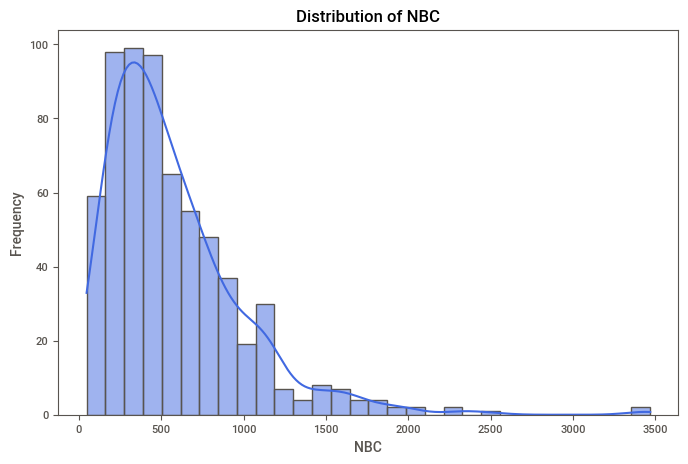

In [120]:

# Plotting the target
plt.figure(figsize=(8, 5))
sns.histplot(data=df_sold, x="NBC", bins=30, kde=True, color="royalblue")
plt.title("Distribution of NBC")
plt.xlabel("NBC")
plt.ylabel("Frequency")
plt.show()

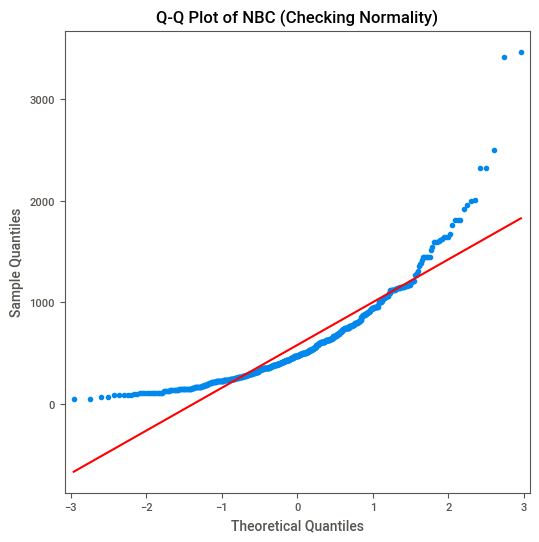

In [121]:
# Plotting a Q-Q plot to check for normality
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot((df_sold["NBC"]), line='s', ax=ax)
ax.set_title("Q-Q Plot of NBC (Checking Normality)")
plt.show()

From these plots I can see the data is skewed and some sort of log transform should help 

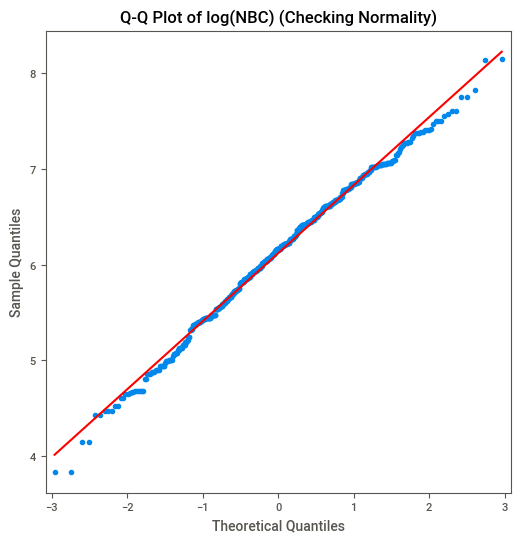

In [122]:
fig, ax = plt.subplots(figsize=(6, 6))
sm.qqplot(np.log(df_sold["NBC"]), line='s', ax=ax)
ax.set_title("Q-Q Plot of log(NBC) (Checking Normality)")
plt.show()

Applying a log transform has matched the data up nicely to a normal distribution. Therefore I will be using a Gamma model with a log link

In [123]:
# Initialising the model
gamma_model = TweedieRegressor(power=2, link='log')

# Creating a pipeline
gamma_pipe = Pipeline([
    ("prep", clone(prep_pipeline)), 
    ("model", gamma_model)
])

# FItting the Pipeline
gamma_pipe.fit(df_sold, df_sold["NBC"])

Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputation',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'),
                                                                   ['Person1 '
                                                                    'Age',
                                                                    'Term',
                                                                    'WGB (No. '
                                                                    'of other '
                                                                    'addresses '
                                                                    'held)',
                                                                    'JF '
                                                                    '(Score)',
                                                                    'X (Months '
                                                                    'same '
                                                                    'person on '
                                                                    'ER at '
                                                                    'current '
                                                                    'address)',
                                                                    'EF (No. '
                                                                    'of people '
                                                                    'not same '
                                                                    'surname '
                                                                    'at '
                                                                    'current '
                                                                    'address)',
                                                                    'BB '
                                                                    '(Number '
                                                                    'o...
                                                    verbose_feature_names_out=False)),
                                 ('encoding',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('one_hot',
                                                                   OneHotEncoder(use_cat_names=True),
                                                                   ['Channel',
                                                                    'Product',
                                                                    'NOB '
                                                                    '(Property '
                                                                    'group)',
                                                                    'URB '
                                                                    '(Income '
                                                                    'group)',
                                                                    'LSB '
                                                                    '(Regional '
                                                                    'banded '
                                                                    'house '
                                                                    'price '
                                                                    'band)'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaling', StandardScaler())])),
                ('model', TweedieRegressor(link='log', po

In [124]:
# Cross validating the model

# Define the scorer
gamma_scorer = make_scorer(mean_tweedie_deviance, power=2, greater_is_better=False)

# Create 5 folds (80/20 split)
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# As using gamma model, will use gamma deviance as the scoring metric
scoring = {"gamma_deviance": gamma_scorer}

# Running CV
cv_results_gamma = cross_validate(
    clone(gamma_pipe), 
    df_sold,
    df_sold["NBC"],
    cv=kf,
    return_train_score=True,
    scoring=scoring
)

# Getting the results
results = pd.DataFrame(columns=["model", "train_gamma_deviance", "test_gamma_deviance"])

entry = {
    "model": "BaseGammaModel",
    "train_gamma_deviance": np.mean(cv_results_gamma["train_gamma_deviance"]),
    "test_gamma_deviance": np.mean(cv_results_gamma["test_gamma_deviance"]),
}

results = pd.concat([results, pd.DataFrame([entry])], ignore_index=True)
results


C:\Users\Store\AppData\Local\Temp\ipykernel_2912\2261328552.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results = pd.concat([results, pd.DataFrame([entry])], ignore_index=True)


,model,train_gamma_deviance,test_gamma_deviance
0,BaseGammaModel,-0.333703,-0.373508


In [125]:
# Checking the coefficients
coefs = gamma_pipe["model"].coef_         
intercept = gamma_pipe["model"].intercept_

feature_names = gamma_pipe.named_steps["prep"].get_feature_names_out()

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Effect": np.exp(coefs) # Expoenntiate the coefficients to get the effect (i.e. how one unit change in the feature affects the target)
})

coef_df.sort_values("Coefficient", ascending=False, key=abs).head(50).round(4)

,Feature,Coefficient,Effect
22,NOB (Property group)_19.0,-0.0616,0.9402
18,NOB (Property group)_23.0,0.0549,1.0565
27,NOB (Property group)_21.0,-0.0546,0.9469
34,URB (Income group)_6.0,0.0544,1.0560
46,LSB (Regional banded house price band)_9.0,-0.0519,0.9494
54,WGB (No. of other addresses held),-0.0500,0.9512
30,NOB (Property group)_2.0,0.0478,1.0489
32,URB (Income group)_4.0,-0.0459,0.9551
16,NOB (Property group)_13.0,-0.0423,0.9586
55,JF (Score),0.0411,1.0420


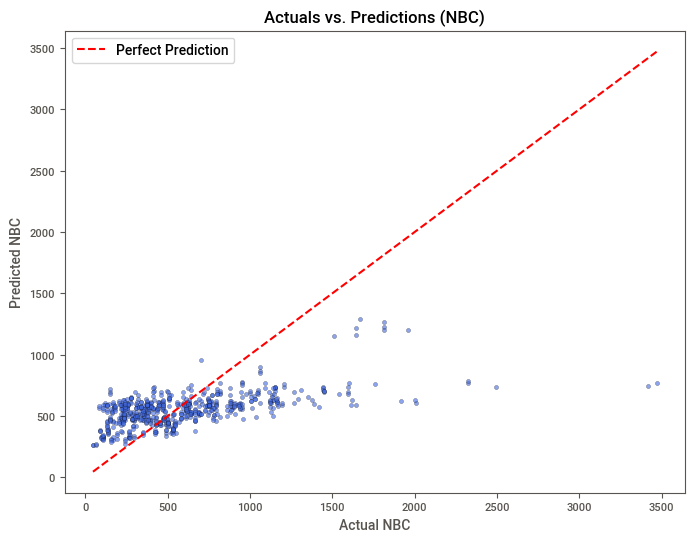

In [126]:
# Plot the Actuals vs. Predictions
actuals = df_sold["NBC"]
preds = gamma_pipe.predict(df_sold)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actuals, y=preds, color="royalblue", edgecolor="k", alpha=0.6)

# Add reference line for perfect predictions
min_val = min(actuals.min(), preds.min())
max_val = max(actuals.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect Prediction")

plt.title("Actuals vs. Predictions (NBC)")
plt.xlabel("Actual NBC")
plt.ylabel("Predicted NBC")
plt.legend()
plt.show()


From looking at the fit of the model, I think we improve the results by capping the target.

c:\Users\Store\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


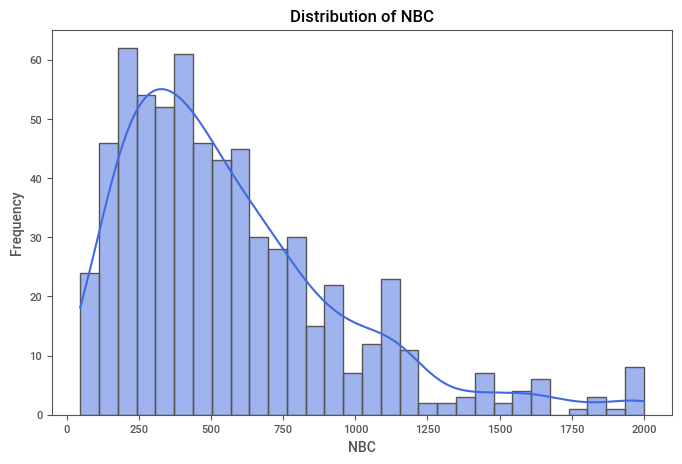

In [127]:
df_sold_cap = df_sold.copy()
df_sold_cap["NBC"] = df_sold_cap["NBC"].clip(upper=2000)

# Plotting the target with x-axis capped at 2500
plt.figure(figsize=(8, 5))
sns.histplot(data=df_sold_cap, x="NBC", bins=30, kde=True, color="royalblue")
plt.title("Distribution of NBC")
plt.xlabel("NBC")
plt.ylabel("Frequency")
plt.show()



In [128]:
gamma_pipe_cap = Pipeline([
    ("prep", clone(prep_pipeline)), 
    ("model", gamma_model)
])

gamma_pipe_cap.fit(df_sold_cap, df_sold_cap["NBC"])

Pipeline(steps=[('prep',
                 Pipeline(steps=[('imputation',
                                  ColumnTransformer(transformers=[('numeric',
                                                                   SimpleImputer(add_indicator=True,
                                                                                 strategy='median'),
                                                                   ['Person1 '
                                                                    'Age',
                                                                    'Term',
                                                                    'WGB (No. '
                                                                    'of other '
                                                                    'addresses '
                                                                    'held)',
                                                                    'JF '
                                                                    '(Score)',
                                                                    'X (Months '
                                                                    'same '
                                                                    'person on '
                                                                    'ER at '
                                                                    'current '
                                                                    'address)',
                                                                    'EF (No. '
                                                                    'of people '
                                                                    'not same '
                                                                    'surname '
                                                                    'at '
                                                                    'current '
                                                                    'address)',
                                                                    'BB '
                                                                    '(Number '
                                                                    'o...
                                                    verbose_feature_names_out=False)),
                                 ('encoding',
                                  ColumnTransformer(remainder='passthrough',
                                                    transformers=[('one_hot',
                                                                   OneHotEncoder(use_cat_names=True),
                                                                   ['Channel',
                                                                    'Product',
                                                                    'NOB '
                                                                    '(Property '
                                                                    'group)',
                                                                    'URB '
                                                                    '(Income '
                                                                    'group)',
                                                                    'LSB '
                                                                    '(Regional '
                                                                    'banded '
                                                                    'house '
                                                                    'price '
                                                                    'band)'])],
                                                    verbose_feature_names_out=False)),
                                 ('scaling', StandardScaler())])),
                ('model', TweedieRegressor(link='log', po

In [129]:
# Cross validating the model

# Running CV
cv_results_gamma = cross_validate(
    clone(gamma_pipe_cap), 
    df_sold_cap,
    df_sold_cap["NBC"],
    cv=kf,
    return_train_score=True,
    scoring=scoring
)

entry = {
    "model": "CappedGammaModel",
    "train_gamma_deviance": np.mean(cv_results_gamma["train_gamma_deviance"]),
    "test_gamma_deviance": np.mean(cv_results_gamma["test_gamma_deviance"]),
}

results = pd.concat([results, pd.DataFrame([entry])], ignore_index=True)
results

,model,train_gamma_deviance,test_gamma_deviance
0,BaseGammaModel,-0.333703,-0.373508
1,CappedGammaModel,-0.323943,-0.360464


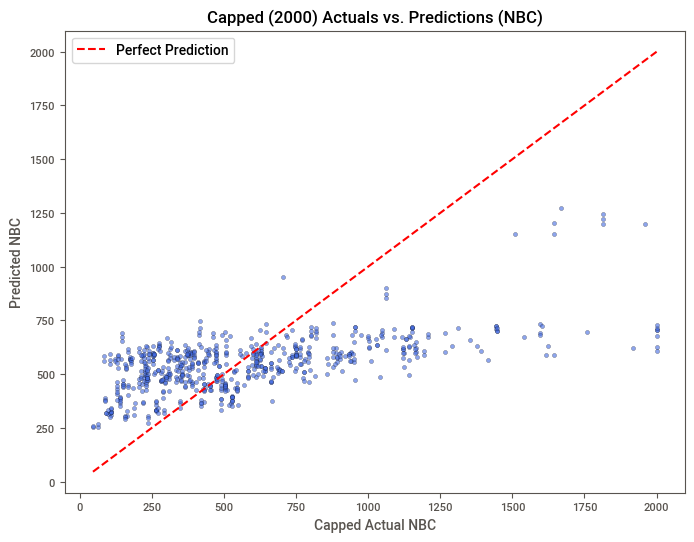

In [130]:
# Plot the Actuals vs. Predictions
actuals = df_sold_cap["NBC"]
preds = gamma_pipe.predict(df_sold_cap)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=actuals, y=preds, color="royalblue", edgecolor="k", alpha=0.6)

# Add reference line for perfect predictions
min_val = min(actuals.min(), preds.min())
max_val = max(actuals.max(), preds.max())
plt.plot([min_val, max_val], [min_val, max_val], color="red", linestyle="--", label="Perfect Prediction")

plt.title("Capped (2000) Actuals vs. Predictions (NBC)")
plt.xlabel("Capped Actual NBC")
plt.ylabel("Predicted NBC")
plt.legend()
plt.show()

In [131]:
# Checking the coefficients
coefs = gamma_pipe["model"].coef_         
intercept = gamma_pipe["model"].intercept_

feature_names = gamma_pipe.named_steps["prep"].get_feature_names_out()

coef_df = pd.DataFrame({
    "Feature": feature_names,
    "Coefficient": coefs,
    "Effect": np.exp(coefs) # Expoenntiate the coefficients to get the effect (i.e. how one unit change in the feature affects the target)
})

coef_df.sort_values("Coefficient", ascending=False, key=abs).head(50).round(4)

,Feature,Coefficient,Effect
22,NOB (Property group)_19.0,-0.0603,0.9415
27,NOB (Property group)_21.0,-0.0540,0.9474
34,URB (Income group)_6.0,0.0519,1.0533
46,LSB (Regional banded house price band)_9.0,-0.0514,0.9499
30,NOB (Property group)_2.0,0.0490,1.0502
54,WGB (No. of other addresses held),-0.0489,0.9522
18,NOB (Property group)_23.0,0.0473,1.0485
32,URB (Income group)_4.0,-0.0441,0.9568
16,NOB (Property group)_13.0,-0.0418,0.9591
55,JF (Score),0.0410,1.0418
